<a href="https://colab.research.google.com/github/nineto1/section_project/blob/main/SC6_AI05_%EC%9D%B4%EA%B3%84%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section6 Project

1. 주 제 : GAN 모델을 이용하여 얼굴 이미지를 생성
2. 목 적 : Tutororial 및 논문을 참고하여 구현 내용을 확인하고, 모델을 구축하는 과정을 통해 모델 구현에 대한 이해를 높이고 경험하고자 함.

3. 모 델 : PGGAN(Progressive GAN) 을 통해 얼굴이미지 생성 시도. 

PGGAN(Progressive GAN) 이란 ?

1. 저해상도 이미지부터 학습을 시작하여 고해상도 층으로 이동하며 점진적으로
   고해상도 이미지를 생성하는 GAN 기법
   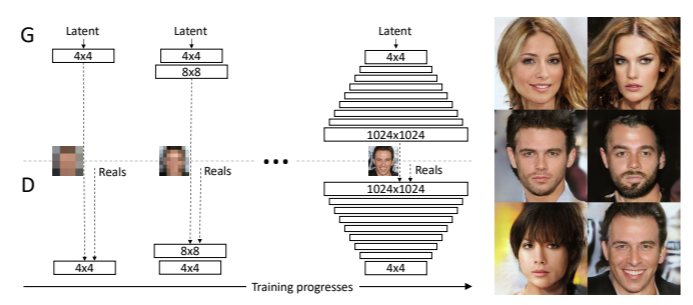

2. 해상도를 증 시키는 과정에서 fade in 기법을 사용 함.

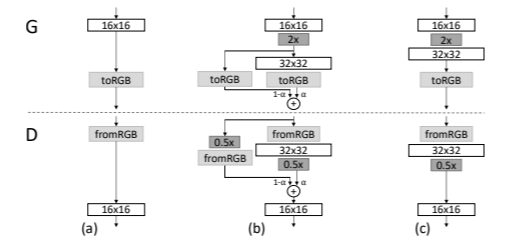

3. Pixelwise normalization
  pixel 단위의 normalization. Generator 에서 사용하는 normaliztion 의 방법으로 layer 의 뒷부분에 추가하여 준다.

  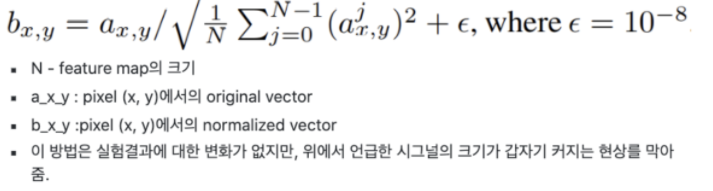

4. MiniBatch Standard Deviation

  한 장의 이미지를 보는 것이 아니라 minibatch 로 묶여진 batch 이미지 전체에서
  vector 들에 대한 표준편차를 계산하여 채널의 마지막에 해당 값을 추가하여 준다.
  이를 통해 Disciriminator 가 real image 와 fake image 를 잘 구별할 수 있도록 하고 Generator 가 풍부한 Variance 를 갖는 이미지를 생성하도록 유도 한다.

5. PGGAN 모델 layer

  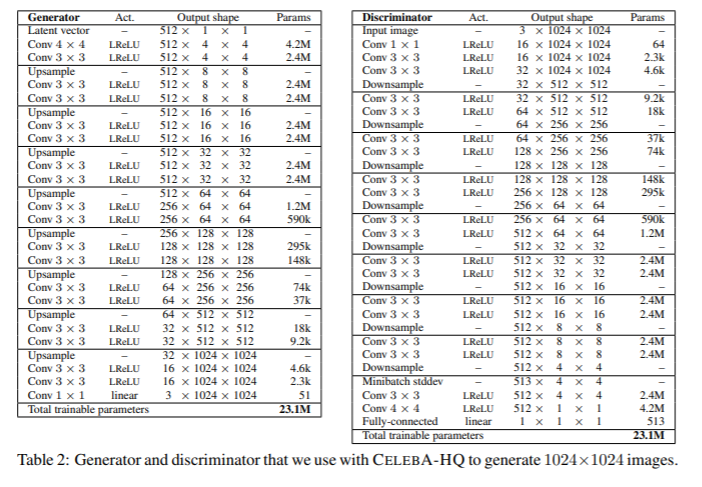

In [ ]:
from os import listdir
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load image file
def load_image(filename) : 
  print(filename)
  image = Image.open(filename)
  image = image.convert('RGB')
  pixels = np.asarray(image)
  return pixels

# load image file in directory and return as array
def load_faces(dir) :  
  faces = []
  id = 0  
  for i, filename in enumerate(listdir(dir)) :
    filepath = dir+'/'+filename 
    print(i)
    pixels = load_image(filepath)
    faces.append(pixels)  
    if len(faces) % 1000 == 0 :
        print('save id ', id)
        np.savez_compressed('/content/drive/MyDrive/celebA_face_np/celeba_512_'+str(id)+'.npz', np.asarray(faces))
        id += 1
        faces.clear()
  
  if len(faces) != 0 : 
      print('save id ', id)
      np.savez_compressed('/content/drive/MyDrive/celebA_face_np/celeba_512_'+str(id)+'.npz', np.asarray(faces))
        

load_faces('/content/drive/MyDrive/celebA_face')

In [ ]:
# image data load
def load_data(dir, n) :    
  file_list = listdir(dir)
  print(file_list)
  filepath = dir+'/'+ file_list[n]
  data = np.load(filepath)    
  return data['arr_0']

dataset = load_data('/content/drive/MyDrive/celebA_split',29)
print(dataset.shape)

['celeba_512_0.npz', 'celeba_512_1.npz', 'celeba_512_2.npz', 'celeba_512_3.npz', 'celeba_512_4.npz', 'celeba_512_5.npz', 'celeba_512_6.npz', 'celeba_512_7.npz', 'celeba_512_8.npz', 'celeba_512_9.npz', 'celeba_512_10.npz', 'celeba_512_11.npz', 'celeba_512_12.npz', 'celeba_512_13.npz', 'celeba_512_14.npz', 'celeba_512_15.npz', 'celeba_512_16.npz', 'celeba_512_17.npz', 'celeba_512_18.npz', 'celeba_512_19.npz', 'celeba_512_20.npz', 'celeba_512_21.npz', 'celeba_512_22.npz', 'celeba_512_23.npz', 'celeba_512_24.npz', 'celeba_512_25.npz', 'celeba_512_26.npz', 'celeba_512_27.npz', 'celeba_512_28.npz', 'celeba_512_30.npz']
(23, 512, 512, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Add, Layer, Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, AveragePooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import backend
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from skimage.transform import resize
from math import sqrt

tf.debugging.enable_check_numerics()


INFO:tensorflow:Enabled check-numerics callback in thread MainThread


In [ ]:
class WeightedSum(Add) :
  def __init__(self, alpha=0.0, **kwargs):
    super(WeightedSum, self).__init__(**kwargs)
    self.alpha = backend.variable(alpha, name='ws_alpha')
  
  def _merge_function(self, input):    
    assert (len(input)==2)
    output = ((1.0 - self.alpha)*input[0]) + (self.alpha*input[1])
    return output

  def get_config(self) : 
    config = super().get_config().copy()
    config.update({'alpha':self.alpha.numpy(),})
    return config

class MinibatchStdev(Layer) :
  def __init__(self, **kwargs) :
    super(MinibatchStdev, self).__init__(**kwargs)
  
  def call(self, inputs) :
    # mean of same pixel position of images
    mean = backend.mean(inputs, axis=0, keepdims=True)
    
    diff_square = backend.square(inputs - mean)
    diff_square_mean = backend.mean(diff_square, axis=0, keepdims=True)
    diff_square_mean += 1e-8
    stdev = backend.sqrt(diff_square_mean)

    mean_pix = backend.mean(stdev, keepdims=True) 

    shape = backend.shape(inputs) 
    output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
    # add mean_pix value to next position of [R,G,B]
    combined = backend.concatenate([inputs, output], axis = -1)
    return combined

  def compute_output_shape(self, input_shape) :
    input_shape = list(input_shape)
    input_shape[-1] += 1
    return tuple(input_shape)

class PixelNormalization(Layer) : 
  def __init__(self, **kwargs) :
    super(PixelNormalization, self).__init__(**kwargs)
  
  def call(self, inputs) :
    values = inputs**2.0
    mean_value = backend.mean(values, axis=-1, keepdims=True)
    mean_value += 1.0e-8

    l2 = backend.sqrt(mean_value)
    normalized = inputs/l2
    return normalized
  
  def comput_output_shape(self, input_shape) :
    return input_shape

In [ ]:
def wasserstein_loss(y_true, y_pred) :  
  return backend.mean(y_true * y_pred)

In [ ]:
def num_of_filter(res) :
  num_filter = { 0: 128,
                 1: 128,
                 2: 128,  # 4x4
                 3: 128,  # 8x8
                 4: 128,  # 16x16
                 5: 128,  # 32x32
                 6: 128,  # 64x64
                 7: 128,  # 128x128
                 8: 128,  # 256x256
                 9: 128,  # 512x512
                 10: 16 }
  return num_filter[int(np.log2(res))]

In [ ]:
def add_discriminator_block(old_model, n_input_layer=3) :
  
  init = RandomNormal(stddev=0.02)
  const = max_norm(1.0)
 
  in_shape = list(old_model.input.shape)
  input_shape = (in_shape[-2]*2, in_shape[-2]*2, in_shape[-1])  

  in_image = Input(shape=input_shape)
  num_filter = num_of_filter(input_shape[-2])
  d = Conv2D(num_filter, (1,1), padding='same', kernel_initializer=init, kernel_constraint = const)(in_image)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(num_filter, (3,3), padding='same', kernel_initializer=init, kernel_constraint = const)(d)
  d = LeakyReLU(alpha=0.2)(d)

  #if num_filter <= 256 : num_filter *= 2
  d = Conv2D(num_filter, (3,3), padding='same', kernel_initializer=init, kernel_constraint = const)(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = AveragePooling2D()(d)
  block_new = d
  for i in range(n_input_layer, len(old_model.layers)) :
    d = old_model.layers[i](d)

  model1 = Model(in_image, d)

  model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

  downsample = AveragePooling2D()(in_image)

  block_old = old_model.layers[1](downsample)
  block_old = old_model.layers[2](block_old)

  # fade in output of old model and input 
  d = WeightedSum()([block_old, block_new])

  for i in range(n_input_layer, len(old_model.layers)):
      d = old_model.layers[i](d)

  model2 = Model(in_image, d)
  model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

  return [model1, model2]

def discriminator(n_blocks, input_shape=(4,4,3)) :
  model_list = list()

  init = RandomNormal(stddev=0.02)
  const = max_norm(1.0)

  # base model for 4x4
  in_image = Input(shape=input_shape)
  num_filter = num_of_filter(input_shape[-2])
  d = Conv2D(num_filter, (1,1), padding='same', kernel_initializer=init, kernel_constraint = const)(in_image)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = MinibatchStdev()(d)
  d = Conv2D(num_filter, (3,3), padding='same', kernel_initializer=init, kernel_constraint = const)(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = Conv2D(num_filter, (4,4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Flatten()(d)
  outout = Dense(1, activity_regularizer=regularizers.l2(1.0e-4), kernel_initializer=init, kernel_constraint=const)(d)

  model = Model(in_image, outout)  
  model.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
 
  model_list.append([model, model])
  

  for i in range(1, n_blocks) :
    old_model = model_list[i - 1][0]
    models = add_discriminator_block(old_model)
    model_list.append(models)

  return model_list

In [ ]:
def add_generator_block(old_model) :
  init = RandomNormal(stddev=0.02)
  const = max_norm(1.0)
  block_end = old_model.layers[-2].output

  upsampling = UpSampling2D()(block_end)
  num_filter = num_of_filter(list(upsampling.shape)[-2])
  g = Conv2D(num_filter, (3,3), padding='same', kernel_initializer=init, kernel_constraint = const)(upsampling)
  g = PixelNormalization()(g)  
  g = LeakyReLU(alpha=0.2)(g)

  g = Conv2D(num_filter, (3,3), padding='same', kernel_initializer=init, kernel_constraint = const)(g)
  g = PixelNormalization()(g)
  g = LeakyReLU(alpha=0.2)(g)  

  # add new output layer
  out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint = const)(g)
  model1 = Model(old_model.input, out_image)

  out_old = old_model.layers[-1]
  out_image2 = out_old(upsampling)  
 
  # fade in for generator
  merged = WeightedSum()([out_image2, out_image])
 
  model2 = Model(old_model.input, merged)
  return [model1, model2]

def generator(latent_dim, n_blocks, in_dim=4):
  model_list = list()
  init = RandomNormal(stddev=0.02)
  const = max_norm(1.0)
  # base mode latent input
  
  in_latent = Input(shape=(latent_dim,))
  num_filter = num_of_filter(in_dim)
  g = Dense(num_filter * in_dim * in_dim, kernel_initializer=init, kernel_constraint = const)(in_latent)
  g = Reshape((in_dim, in_dim, num_filter))(g)
  
  g = Conv2D(num_filter, (4,4), padding='same', kernel_initializer=init, kernel_constraint = const)(g)
  g = PixelNormalization()(g)
  g = LeakyReLU(alpha=0.2)(g)

  g = Conv2D(num_filter, (3,3), padding='same', kernel_initializer=init, kernel_constraint = const)(g)
  g = PixelNormalization()(g)
  g = LeakyReLU(alpha=0.2)(g)

  out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint = const)(g)

  model = Model(in_latent, out_image)
  model_list.append([model, model])

  for i in range(1, n_blocks) : 
    old_model = model_list[i-1][0]
    models = add_generator_block(old_model)
    model_list.append(models)
  return model_list

In [ ]:
def composite(discriminator, generator) : 
  model_list = list()
  for i in range(len(discriminator)) :
    g_models, d_models = generator[i], discriminator[i]
    # straight-through model
    d_models[0].trainable = False
    model1 = Sequential()
    model1.add(g_models[0])
    model1.add(d_models[0])
    model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

    # fade in model
    d_models[1].trainable = False
    model2 = Sequential()
    model2.add(g_models[1])
    model2.add(d_models[1])
    model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

    model_list.append([model1, model2])
  return model_list



In [ ]:
def resize_dataset(images, new_shape):
  image_list = list()
  for image in images :
    #resize image and store
    new_image = resize(image, new_shape, 0)
    image_list.append(new_image)

  return np.asarray(image_list)

In [ ]:
def update_fadein(models, step, n_steps) :
  # calculate alpha for current step
  alpha = step / float(n_steps - 1)  
  # update alphe
  for model in models : 
    for layer in model.layers :
      if isinstance(layer, WeightedSum) :
        backend.set_value(layer.alpha, alpha)

In [ ]:
def generate_real_samples(dataset, n_samples) : 
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  x = dataset[ix]  
  y = np.ones((n_samples, 1))
  return x, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):	
  x_input = np.random.randn(latent_dim * n_samples)	
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples) :
  x_input = generate_latent_points(latent_dim, n_samples)
  x = generator.predict(x_input)  
  y = -np.ones((n_samples, 1))
  return x, y

In [ ]:
# image data load
def load_data(dirlist, n) :    
  filepath = '/content/drive/MyDrive/celebA_split'
  filename = filepath+'/'+ dirlist[n]  
  data = np.load(filename)
  print(f'load data, {filename}')
  x = data['arr_0']
  x = x.astype('float64')
  return (x - 127.5) / 127.5

In [ ]:
def train_epochs(g_model, d_model, gan_model, dataset, n_epochs, n_batch, fadein=False):
  # number of batch
  bat_per_epo = int(dataset.shape[0] / n_batch)
  # number of training iteration
  n_steps = bat_per_epo * n_epochs
  
  half_batch = int(n_batch // 2)

  for i in range(n_steps) : 
    if fadein : 
      update_fadein([g_model, d_model, gan_model], i, n_steps)
    X_real, y_real = generate_real_samples(dataset, half_batch)
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    
    if d_model.trainable == False :       
       d_model.trainable = True

    d_loss1 = d_model.train_on_batch(X_real, y_real)    
    d_loss2 = d_model.train_on_batch(X_fake, y_fake)

    z_input = generate_latent_points(latent_dim, n_batch)
    y_real2 = np.ones((n_batch, 1))

    if gan_model.layers[1].trainable == True :       
       gan_model.layers[1].trainable = False

    g_loss = gan_model.train_on_batch(z_input, y_real2)

    print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))

In [ ]:
def summarize_performance(status, g_model, latent_dim, n_samples=25):
  # devise name
  gen_shape = g_model.output_shape
  name = '%03dx%03d-%s' % (gen_shape[1], gen_shape[2], status)
  # generate images
  X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
  # normalize pixel values to the range [0,1]
  X = (X - X.min()) / (X.max() - X.min())
  # plot real images
  square = int(np.sqrt(n_samples))
  for i in range(n_samples):
    plt.subplot(square, square, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])
  # save plot to file
  filename1 = 'plot_%s.png' % (name)
  plt.savefig('/content/drive/MyDrive/result/image/'+filename1)
  plt.close()
  # save the generator model
  filename2 = 'model_%s.h5' % (name)
  g_model.save('/content/drive/MyDrive/result/model/'+filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
def train(g_models, d_models, gan_models, dataset, latent_dim, e_norm, e_fadein, n_batch):
  g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
  gen_shape = g_normal.output_shape  
  resized_data = resize_dataset(dataset, gen_shape[1:])  
  print(f'resized data shape {resized_data.shape}')
  train_epochs(g_normal, d_normal, gan_normal, resized_data, e_norm[0], n_batch[0])
  summarize_performance('tuned', g_normal, latent_dim)
  for i in range(1, len(g_models)):
    [g_normal, g_fadein] = g_models[i]
    [d_normal, d_fadein] = d_models[i]
    [gan_normal, gan_fadein] = gan_models[i]
    gen_shape = g_normal.output_shape
    resized_data = resize_dataset(dataset, gen_shape[1:])
    print(f'resized data shape {resized_data.shape}')
    # train fade in 
    train_epochs(g_fadein, d_fadein, gan_fadein, resized_data, e_fadein[i], n_batch[i], True)            
    summarize_performance('faded', g_fadein, latent_dim)
    # train normal
    train_epochs(g_normal, d_normal, gan_normal, resized_data, e_norm[i], n_batch[i])
    summarize_performance('tuned', g_normal, latent_dim)    


In [ ]:
# number of growth phase, eg. 8 = [4, 8, 16, 32, 64, 128, 256, 512]
n_blocks= 6
latent_dim = 100
# create discrimiator
d_models = discriminator(n_blocks)
# create generator
g_models = generator(latent_dim, n_blocks)
# composition to train generator based on discriminator
gan_models = composite(d_models, g_models)

data_list = listdir('/content/drive/MyDrive/celebA_split')

# train model
n_batch = [16, 16, 16, 16, 16, 16, 6, 4]
n_epochs = [5, 8, 8, 10, 10, 10, 10, 10]

for i in range(0, 10) :
  dataset = load_data(data_list, i)
  train(g_models, d_models, gan_models, dataset, latent_dim, n_epochs, n_epochs, n_batch)

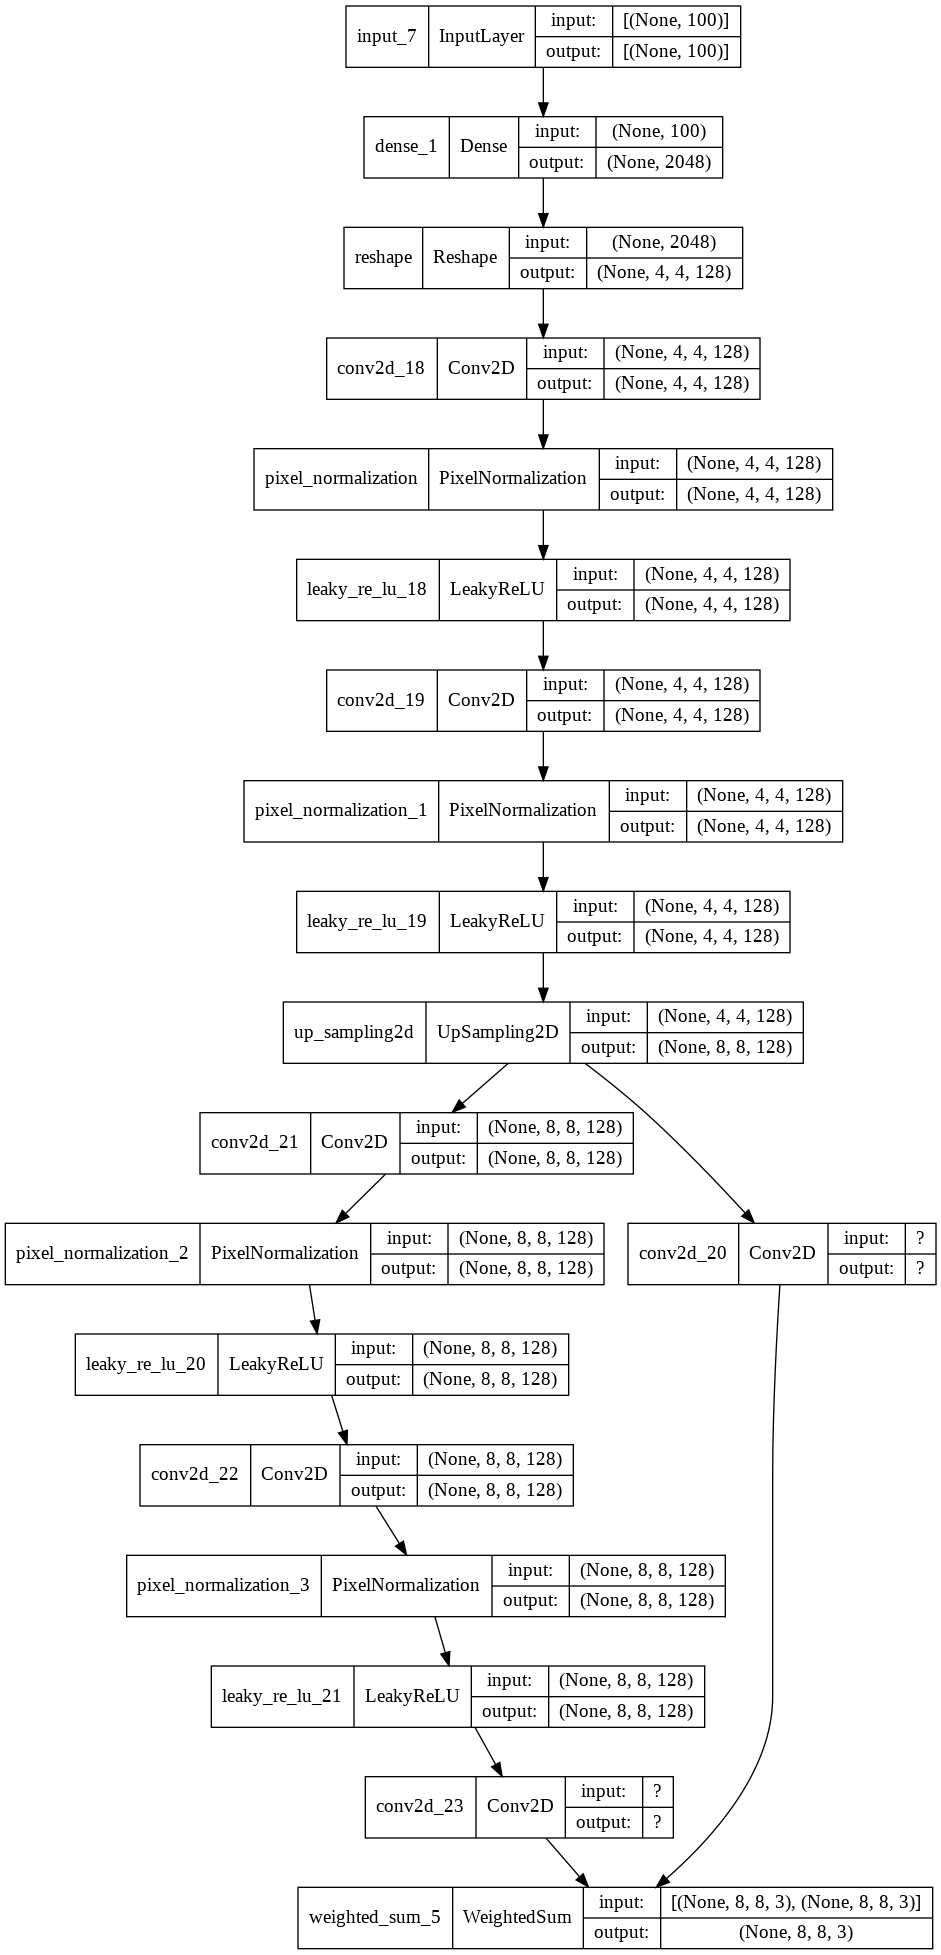

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(g_models[1][1], to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

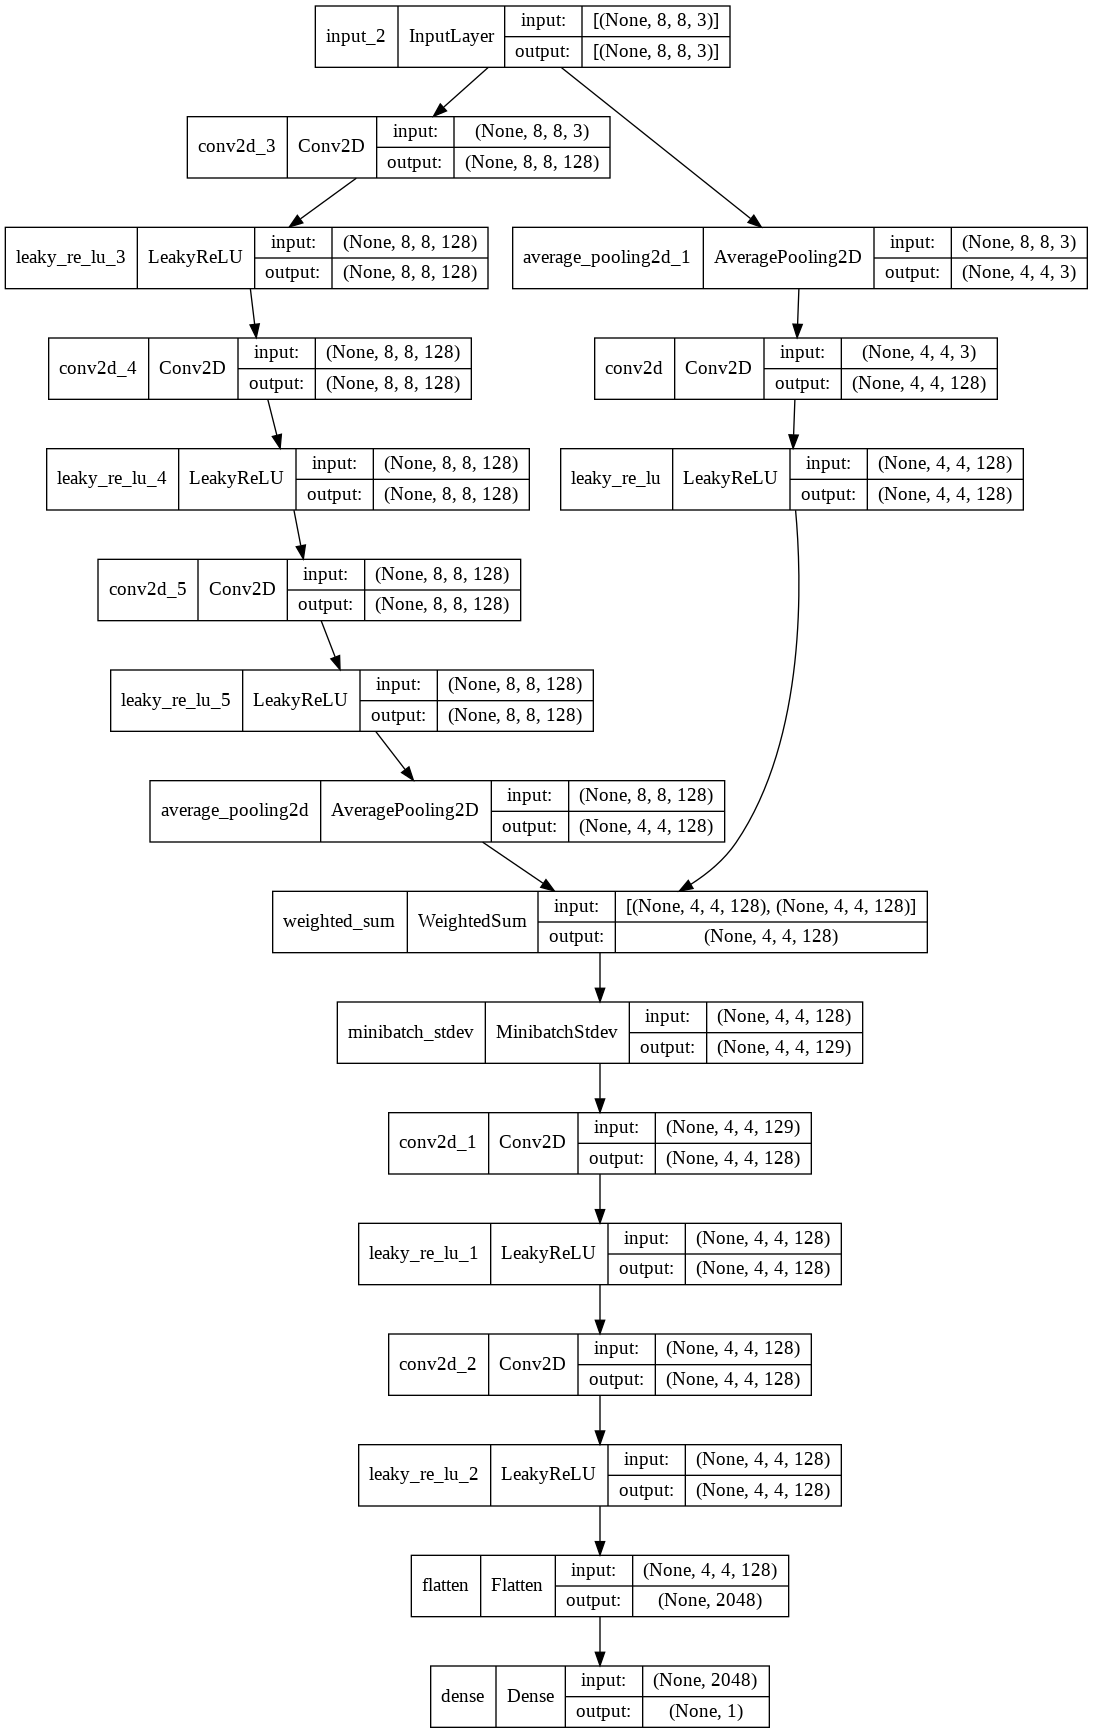

In [ ]:
plot_model(d_models[1][1], to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

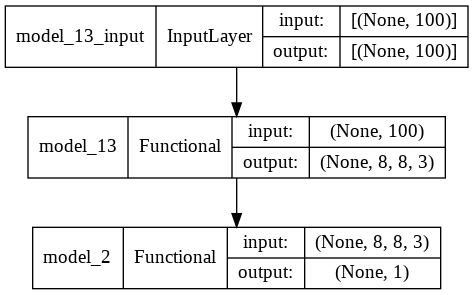

In [ ]:
plot_model(gan_models[1][1], to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)